<a href="https://colab.research.google.com/github/AdrianaThomaz/sistema_fotovoltaico_grafic_consumo/blob/main/sistema_solar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=== Consumo estimado por equipamento (Wh/dia) ===
             Equipamento  Wh_por_dia                                    Notas
               Fogareiro      2750.0                              08:00-13:00
        Computador (CPU)      2000.0                              07:00-17:00
             Modem Wi-Fi       255.0                   06:00-23:00 (estimado)
Carregadores (2cel+2tab)       180.0                     Carga total estimada
     Freezer Consul 414L       260.0 Estimado 260 Wh/dia (compressor cíclico)
        Máquina de lavar      2400.0        Só finais de semana (09:00-12:00)
          Liquidificador        50.0                      10 min ≈ 0,167h/dia
 Furadeira+Serra (média)         1.5               ≈36 Wh/dia (30 min/semana)

=== Resumo geral ===
                       Métrica  Valor
     Geração estimada (Wh/dia) 7938.0
     Consumo dia útil (Wh/dia) 5496.5
Consumo fim de semana (Wh/dia) 7896.5
       Bateria utilizável (Wh) 3600.0


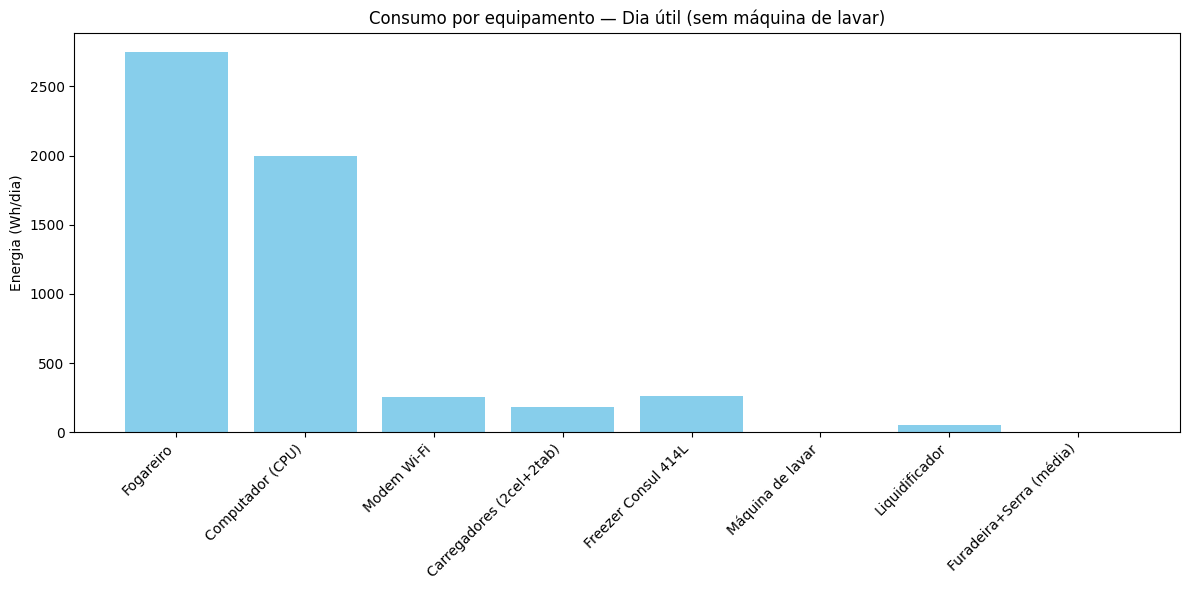

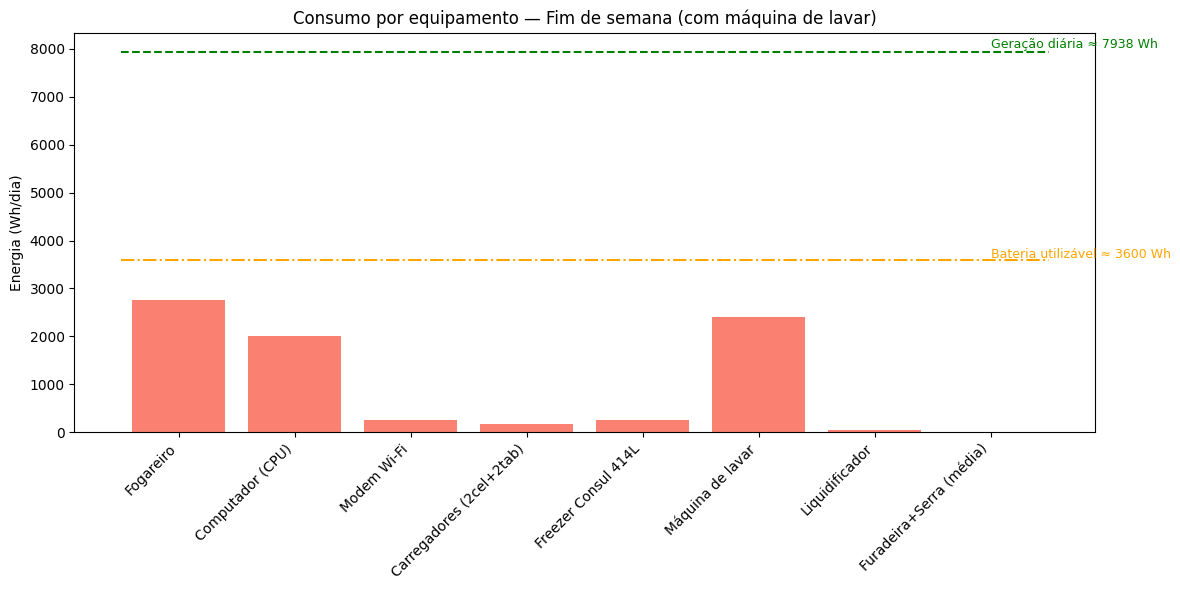

In [1]:
# --- Simulação de consumo vs geração solar em sistema off-grid ---
# Perfil: Fogareiro, PC, modem, freezer, máquina de lavar, etc.
# Autor: baseado no modelo que rodamos aqui

import pandas as pd
import matplotlib.pyplot as plt

# --------------------------------
# Configurações do sistema
# --------------------------------
generation_daily_wh = 7938.0   # Geração solar estimada (Wh/dia) -> 4x405W, 7h sol, perdas 30%
usable_battery_wh = 3600.0     # Energia utilizável do banco (Wh) -> 2x150Ah 24V (50% DOD)

# --------------------------------
# Perfil de equipamentos
# --------------------------------
devices = [
    {"Equipamento":"Fogareiro", "Potência_W":550, "Horas_por_dia_uso":5, "Notas":"08:00-13:00"},
    {"Equipamento":"Computador (CPU)", "Potência_W":200, "Horas_por_dia_uso":10, "Notas":"07:00-17:00"},
    {"Equipamento":"Modem Wi-Fi", "Potência_W":15, "Horas_por_dia_uso":17, "Notas":"06:00-23:00 (estimado)"},
    {"Equipamento":"Carregadores (2cel+2tab)", "Potência_W":60, "Horas_por_dia_uso":3, "Notas":"Carga total estimada"},
    {"Equipamento":"Freezer Consul 414L", "Potência_W":0, "Horas_por_dia_uso":0, "Notas":"Estimado 260 Wh/dia (compressor cíclico)", "Wh_dia":260},
    {"Equipamento":"Máquina de lavar", "Potência_W":800, "Horas_por_dia_uso":3, "Notas":"Só finais de semana (09:00-12:00)"},
    {"Equipamento":"Liquidificador", "Potência_W":300, "Horas_por_dia_uso":1/6, "Notas":"10 min ≈ 0,167h/dia"},
    {"Equipamento":"Furadeira+Serra (média)", "Potência_W":500, "Horas_por_dia_uso":36/500/24, "Notas":"≈36 Wh/dia (30 min/semana)"}
]

# --------------------------------
# Cálculo de consumo por equipamento
# --------------------------------
rows = []
for d in devices:
    name = d["Equipamento"]
    if "Wh_dia" in d:
        wh_day = d["Wh_dia"]  # usa valor fixo informado (freezer)
    else:
        wh_day = d["Potência_W"] * float(d["Horas_por_dia_uso"])
    rows.append({"Equipamento": name, "Wh_por_dia": round(wh_day,1), "Notas": d["Notas"]})

df_devices = pd.DataFrame(rows)

# --------------------------------
# Consumo total
# --------------------------------
weekday_consumption = df_devices[df_devices["Equipamento"]!="Máquina de lavar"]["Wh_por_dia"].sum()
weekend_consumption = df_devices["Wh_por_dia"].sum()

# Resumo
df_summary = pd.DataFrame([
    ["Geração estimada (Wh/dia)", generation_daily_wh],
    ["Consumo dia útil (Wh/dia)", round(weekday_consumption,1)],
    ["Consumo fim de semana (Wh/dia)", round(weekend_consumption,1)],
    ["Bateria utilizável (Wh)", usable_battery_wh]
], columns=["Métrica","Valor"])

# --------------------------------
# Saída: tabelas
# --------------------------------
print("=== Consumo estimado por equipamento (Wh/dia) ===")
print(df_devices.to_string(index=False))
print("\n=== Resumo geral ===")
print(df_summary.to_string(index=False))

# --------------------------------
# Gráficos
# --------------------------------
labels = df_devices["Equipamento"].tolist()
weekday_vals = df_devices.apply(lambda r: 0 if r["Equipamento"]=="Máquina de lavar" else r["Wh_por_dia"], axis=1).tolist()
weekend_vals = df_devices["Wh_por_dia"].tolist()

# Gráfico dia útil
plt.figure(figsize=(12,6))
plt.bar(labels, weekday_vals, color="skyblue")
plt.title("Consumo por equipamento — Dia útil (sem máquina de lavar)")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Energia (Wh/dia)")
plt.tight_layout()
plt.show()

# Gráfico fim de semana
plt.figure(figsize=(12,6))
plt.bar(labels, weekend_vals, color="salmon")
plt.title("Consumo por equipamento — Fim de semana (com máquina de lavar)")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Energia (Wh/dia)")

# linhas de geração e bateria
plt.hlines(generation_daily_wh, xmin=-0.5, xmax=len(labels)-0.5, linestyles='dashed', colors='green')
plt.hlines(usable_battery_wh, xmin=-0.5, xmax=len(labels)-0.5, linestyles='dashdot', colors='orange')
plt.annotate(f"Geração diária ≈ {int(generation_daily_wh)} Wh",
             xy=(len(labels)-1, generation_daily_wh*1.01), fontsize=9, color='green')
plt.annotate(f"Bateria utilizável ≈ {int(usable_battery_wh)} Wh",
             xy=(len(labels)-1, usable_battery_wh*1.01), fontsize=9, color='orange')

plt.tight_layout()
plt.show()